In [1]:
import string

import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc

In [2]:
DATA_PATH = "./twitter-suicidal_data.csv"
SAMPLE_NUMBERS = 4

# Data Exploration

## Load Data

In [3]:
df = pd.read_csv(DATA_PATH)

## Data statistics

In [4]:
df.head(5)

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


In [6]:
print(f"Number of samples: {len(df)}")

Number of samples: 9119


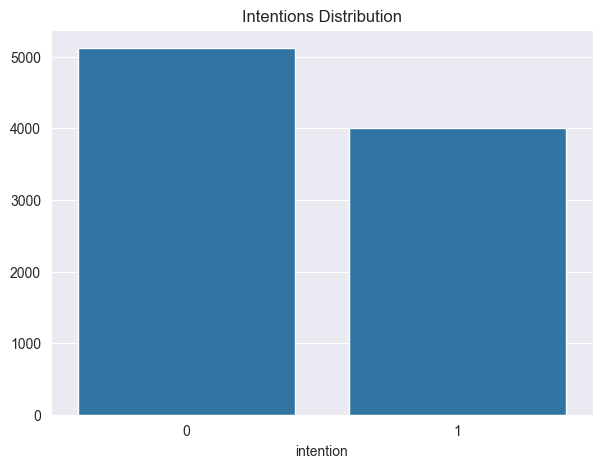

In [7]:
intentions = df["intention"].value_counts()

plt.figure(figsize=(7, 5))
sns.barplot(x=intentions.index, y=intentions.values)
plt.title("Intentions Distribution")
plt.show()

# Data Preprocessing

In [16]:
import nltk
import emoji
import re

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

nltk.download(["stopwords", "punkt", "wordnet"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pooyasadeghi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pooyasadeghi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pooyasadeghi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
def convert_emoji_to_text(text):
    return emoji.demojize(text, delimiters=(" ", " "))

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:          
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    0. concatenation of the text (not necessary)
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """
    # text = ''.join(text)
    # lowercase the text
    text = text.lower()
    # remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # remove numbers
    text = re.sub(r"\d+", "", text)
    # remove urls,
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # remove usernames
    text = re.sub(r'@\S+', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # convert emojis to text
    text = convert_emoji_to_text(text)
    # remove non-word characters
    text = re.sub(r"[^\w\s]", "", text)
    # lemmatization and tokenization of the text
    tokenized = nltk.word_tokenize(text)
    pos_tag = nltk.pos_tag(tokenized)
    tokens = [
        lemmatizer.lemmatize(token, nltk_pos_tagger(tag))
        for token, tag in pos_tag
    ]
    # remove stopwords
    tokens = [token for token in tokens if token not in stopwords]
    
    return tokens
    

In [32]:
def format_length_bound(text: str, length:int):
    if len(text) <= length:
        return text
    mm = length // 2 - 3
    rr = length - mm - 5
    return text[:mm] + "|...|" + text[-rr:]
    
def draw_sample_processing(dataframe: pd.DataFrame, sample_numbers: int = SAMPLE_NUMBERS, show=True):
    sample_text = dataframe.sample(sample_numbers)
    label_rawT_procT = [
        (label, tweet, preprocess_data(tweet)) 
        for tweet, label in zip(sample_text["tweet"], sample_text["intention"])
    ]
    if show:
        for idx, (label, rawT, procT) in enumerate(label_rawT_procT, start=1):
            procT = str(procT)
            print(f"Sample {idx}:")
            print(f":::::::Label          : {label}")
            print(f":::::::Raw Tweet      : {format_length_bound(rawT, 50):<50} ({len(rawT)})")
            print(f":::::::Processed Tweet: {format_length_bound(procT, 50):<50} ({len(procT)})")
        return 
    return pd.DataFrame(label_rawT_procT, columns=["Intention", "Raw Tweet", "Processed Tweet"])

In [33]:
draw_sample_processing(df, show=True)

Sample 1:
:::::::Label          : 0
:::::::Raw Tweet      : went to office on sund|...|wer went off in office  (54)
:::::::Processed Tweet: ['go', 'office', 'sund|...|power', 'go', 'office'] (51)
Sample 2:
:::::::Label          : 1
:::::::Raw Tweet      : i dont feel very good |...|help much to be honest  (474)
:::::::Processed Tweet: ['dont', 'feel', 'good|...|elp', 'much', 'honest'] (446)
Sample 3:
:::::::Label          : 1
:::::::Raw Tweet      : amjust angry that i ex|...|ust want it all to stop (1124)
:::::::Processed Tweet: ['amjust', 'angry', 'e|...|ymore', 'want', 'stop'] (930)
Sample 4:
:::::::Label          : 0
:::::::Raw Tweet      : i don t want to to to work today                   (33)
:::::::Processed Tweet: ['want', 'work', 'today']                          (25)
